# Import libraries

In [1]:
import os
import sys
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import importlib
from process_frames import Processor

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import joblib
import seaborn as sn

# Choose options ang configurate
If you want to process image, set PROCESS_IMAGES to True

If you want to process data, set PROCESS_DATA to True

In [2]:
seed = 2541
PROCESS_IMAGES = False
PROCESS_DATA = False

# List images

In [3]:
path = os.getcwd()
path_color = '../data/color/'
path_depth = '../data/depth/'
path_mosaic = '../data/mosaic/'

#Create mosaic path if it not exits
if (not os.path.isdir(path_mosaic)):
    os.mkdir(path_mosaic)

file_list = glob.glob(path_color+"*")
file_list = [os.path.basename(filename) for filename in file_list]

print(len(file_list),"images found")

2069 images found


# Generate data

In [4]:
if PROCESS_IMAGES:
    processor = Processor()
    areas = {filename: processor.process_image(depth_filename=os.path.join(path_depth, filename),
                          color_filename=os.path.join(path_color, filename),
                          mosaic_path=path_mosaic) for filename in file_list}
    # Prepare data
    remove_areas = []
    for area in areas:    
        if areas[area] is None:  
            remove_areas.append(area)
    for remove in remove_areas:
        del areas[remove]
    areas_dataframe = pd.DataFrame.from_dict(areas, orient='index',
         columns=['area', 'width', 'height', 'MA', 'ma', 'per_area', 'eccentricity', 'perimeter', 'symmetry', 'mask_method'])
    areas_dataframe.index.name = 'uuid'
    areas_dataframe.index = areas_dataframe.index.str.replace('.npy', '',)
    print("Generated data")
    display(areas_dataframe.head())
    
    # Read csv file with weights
    weight_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid.csv'), usecols=['uuid', 'id', 'sex', 'weight'])
    print("Loaded data")
    display(weight_data.head())
    
    # Save calculated information in csv file
    mix = pd.merge(weight_data, areas_dataframe, on='uuid', how='inner')
    weight_col = mix.pop('weight')    
    mix.insert(12, 'weight', weight_col)
    mix.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'))
    print("Final data")
    display(mix.head())

# Process data
Sex has been coded as 1: 'Female', 0: 'Male'

In [5]:
#Load file data
file_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'), usecols=['uuid', 'id', 'sex', 'weight', 'area', 'width', 'height', 'MA', 'ma', 'per_area', 'eccentricity', 'perimeter', 'symmetry', 'mask_method'])
file_data = file_data.reindex(columns=['uuid', 'id', 'sex', 'area', 'width', 'height', 'MA', 'ma', 'eccentricity', 'perimeter', 'per_area', 'symmetry', 'weight', 'mask_method'])
display(file_data.head())
print(len(file_data),"images loaded \n")

,uuid,id,sex,area,width,height,MA,ma,eccentricity,perimeter,per_area,symmetry,weight,mask_method
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,298443.224602,567,316,587.206360,229.859222,0.920201,1873.976826,46.974570,0.309226,24.5,LAB_closing
1,960fd92c91f541f6b85889426c39a0fe,0261,1,318302.918181,659,258,687.358032,226.256454,0.944271,1999.373795,59.763893,0.349275,27.1,LAB_closing
2,ca10f050724d47f5971c3530ef341a8d,0236,0,309138.654556,572,328,668.467163,169.806076,0.967198,1743.190029,36.677459,0.306024,25.5,LAB_opening
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,273581.342138,622,216,631.514832,194.361923,0.951460,1715.383900,60.970938,0.375683,25.8,LAB_closing
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,303632.475265,520,348,568.773926,199.193405,0.936669,1651.709800,41.775969,0.364584,25.5,LAB_closing


1819 images loaded 



In [6]:
file_data['mask_method'].value_counts()

LAB_closing     1194
Gray_opening     418
LAB_opening      207
Name: mask_method, dtype: int64

In [7]:
print("Stadistics of data")
file_data.describe()['weight']

Stadistics of data


count    1819.000000
mean       22.233150
std         4.731409
min        13.500000
25%        17.700000
50%        24.000000
75%        26.800000
max        27.700000
Name: weight, dtype: float64

Total: 		1819
Filter: 	1042	Filter (%): 	57.28
Discard: 	777	Discard (%): 	42.72


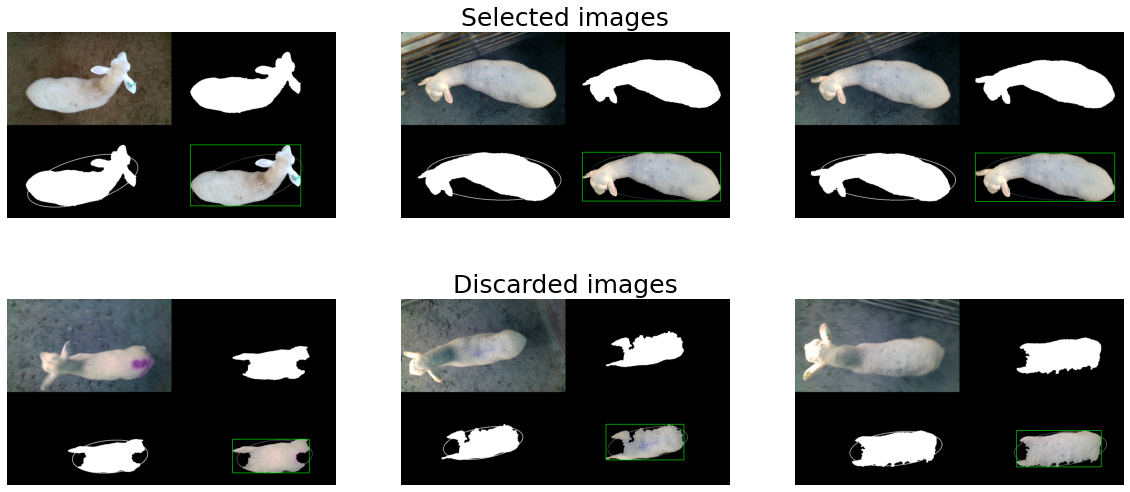

In [8]:
file_data['area_bb'] = file_data.apply(lambda x: x.width*x.height, axis=1)
good_data = file_data.loc[(file_data['area_bb']>=180000) & (file_data['area']>=220000)].sort_values(by=['area_bb'],ignore_index=True)
bad_data = file_data.loc[(file_data['area_bb']<180000) | (file_data['area']<220000)].sort_values(by=['area_bb'],ignore_index=True)
print('Total: \t\t'+str(file_data.shape[0]))
print('Filter: \t'+str(good_data.shape[0])+'\tFilter (%): \t'+"{:.2f}".format((good_data.shape[0]/file_data.shape[0])*100))
print('Discard: \t'+str(bad_data.shape[0])+'\tDiscard (%): \t'+"{:.2f}".format((bad_data.shape[0]/file_data.shape[0])*100))

max_images = 10
fig, axs = plt.subplots(2,3, figsize=(20,9))
for i in range(0,3):
    file = good_data.loc[(i*15)]
    img=mpimg.imread(os.path.join("..", 'data', 'mosaic', file.uuid+'_mosaico.png'))
    axs[0][i].imshow(img)
    axs[0][i].axis('off')

    file = bad_data.loc[(i*15)]
    img=mpimg.imread(os.path.join("..", 'data', 'mosaic', file.uuid+'_mosaico.png'))
    axs[1][i].imshow(img)
    axs[1][i].axis('off')
    
axs[0][1].title.set_text('Selected images')
axs[0][1].title.set_size(25)
axs[1][1].title.set_text('Discarded images')
axs[1][1].title.set_size(25)

plt.savefig(os.path.join("..", 'data', 'img_filter_data.png'), bbox_inches='tight', dpi=300)
plt.show()

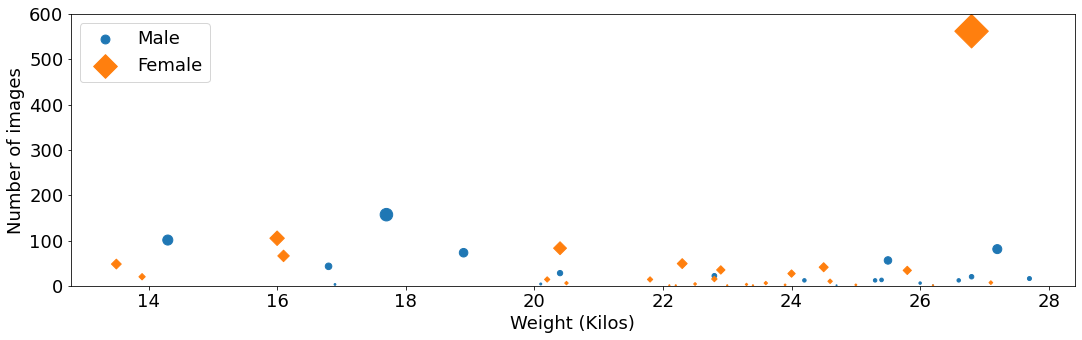

In [9]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (18,5)

male_data = file_data[file_data['sex']==0]
female_data = file_data[file_data['sex']==1]

female_c = female_data['weight'].value_counts()
male_c = male_data['weight'].value_counts()


plt.scatter(male_c.index, male_c.values, label='Male', s= male_c.values, marker='o')
plt.scatter(female_c.index, female_c.values, label='Female', s= female_c.values, marker='D')

plt.xlabel('Weight (Kilos)')
plt.ylabel('Number of images')
plt.ylim([0,600])
plt.legend(loc = "upper left")
plt.savefig(os.path.join("..", 'data', 'img_hist_weight.png'), bbox_inches='tight', dpi=300)

plt.show()

In [10]:
# Separate inputs and output
X = good_data.loc[:, 'area':'symmetry']
print("X data")
display(X.head())

y = good_data.loc[:, ['weight']]
print("y data")
display(y.head())

#Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

if PROCESS_DATA:  
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    linearRegression = LinearRegression()   
    ridge = Ridge()
    ridgecv = RidgeCV()
    lasso = Lasso()
    lassocv = LassoCV()
    lassolars = LassoLars()
    lassolarscv = LassoLarsCV()
    decisionTree = DecisionTreeRegressor(random_state=seed)

    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[linearRegression], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[ridge], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[ridgecv], 'classifier__fit_intercept': [True,False], 'classifier__scoring':['r2']},
                      {'classifier':[lasso], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1), 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassocv], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassolars], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[lassolarscv], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[decisionTree], 'classifier__criterion':['mse', 'friedman_mse', 'mae'], 'classifier__max_features': ['auto', 'sqrt', 'log2']}
                 ]

    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                       'neg_root_mean_squared_error', 'neg_median_absolute_error']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())

    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'ridge': ridge,
                 'ridgecv': ridgecv,
                 'lasso': lasso,
                 'lassocv': lassocv,
                 'lassolars': lassolars,
                 'lassolarscv': lassolarscv,
                 'decisionTree': decisionTree
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump'))    
else:
    #Load last models
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*_model.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    linearRegression = models['linearRegression']
    ridge = models['ridge']
    ridgecv = models['ridgecv']
    lasso= models['lasso']
    lassocv = models['lassocv']
    lassolars = models['lassolars']
    lassolarscv = models['lassolarscv']
    decisionTree = models['decisionTree']

X data


,area,width,height,MA,ma,eccentricity,perimeter,per_area,symmetry
0,301383.980789,570,316,588.858276,229.705048,0.920779,1887.533175,46.847078,0.315828
1,270683.082065,715,252,693.196533,246.389130,0.934699,1994.344357,58.578042,0.286230
2,270683.082065,715,252,693.196533,246.389130,0.934699,1994.344357,58.578042,0.286230
3,270683.082065,715,252,693.196533,246.389130,0.934699,1994.344357,58.578042,0.286230
4,270683.082065,715,252,693.196533,246.389130,0.934699,1994.344357,58.578042,0.286230


y data


,weight
0,24.5
1,26.8
2,26.8
3,26.8
4,26.8


# Evaluate best model

In [11]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)
print(gs.best_params_)

results = pd.DataFrame(gs.cv_results_)
results['param_classifier'] = results.param_classifier.astype(str).str.split('(', expand=True)[0]
best_results_by_model = pd.pivot_table(data=results,
               index='param_classifier',
               values = ['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error'], axis=1)
print('Mean scores during Cross Validation')
best_results_by_model.sort_values(by='mean_test_r2', ascending=False, inplace=True)
best_results_by_model['mean_test_r2'] = best_results_by_model['mean_test_r2']*100
best_results_by_model['mean_test_explained_variance'] = best_results_by_model['mean_test_explained_variance']*100
best_results_by_model['std_test_r2'] = best_results_by_model['std_test_r2']*100
best_results_by_model['std_test_explained_variance'] = best_results_by_model['std_test_explained_variance']*100
display((best_results_by_model).round(4))

#Save results in latex file
with open(os.path.join("..", 'data', 'results_by_model.tex'), 'w') as tf:
     tf.write(best_results_by_model.to_latex(float_format="%.2f"))

Best model: DecisionTreeRegressor(criterion='mae', max_features='auto', random_state=2541)
{'classifier': DecisionTreeRegressor(criterion='mae', max_features='auto', random_state=2541), 'classifier__criterion': 'mae', 'classifier__max_features': 'auto'}
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,std_test_r2,std_test_explained_variance,std_test_max_error
param_classifier,,,,,,
DecisionTreeRegressor,94.8595,94.9747,-5.5100,4.8828,4.7458,2.3978
LassoLarsCV,76.4436,76.7479,-6.5040,9.6379,9.3628,1.3921
LinearRegression,76.4436,76.7479,-6.5040,9.6060,9.3348,1.3921
LassoCV,76.4236,76.7291,-6.4394,11.6071,11.1844,2.0878
RidgeCV,76.3892,76.7037,-6.3658,9.8233,9.5265,1.5249
Ridge,75.1432,75.4843,-6.3823,12.3418,11.7546,2.3209
LassoLars,39.8113,45.6504,-9.7449,34.9111,11.0421,1.7030
Lasso,39.7958,45.6368,-9.2670,34.8945,11.0370,1.7024


In [12]:
def mean_relative_error(y_real, y_predicted):
    y_real = np.reshape(y_real, (-1,1))
    y_predicted = np.reshape(y_predicted, (-1,1))
    N = y_real.shape[0]    
    return (np.sum(abs(y_real-y_predicted)/y_real)/N)[0]

In [13]:
print('TEST DATA')
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Mean Square Error:', mean_squared_error(y_test, best_estimator_predictions))
print('Explained variance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))
print('Mean relative error:', mean_relative_error(y_test, best_estimator_predictions))

TEST DATA
R2 score: 0.9769875940075768
Mean Square Error: 0.37463258785942477
Explained variance score: 0.9769901020090734
Max error: 6.899999999999999
Mean absolute error: 0.10031948881789136
Mean relative error: 0.004822117958257217


In [14]:
predicted_data = good_data.loc[X_test.index]
predicted_data.insert(13, "predicted_weight", best_estimator_predictions, True)
predicted_data.insert(14, "difference", abs(predicted_data['weight']-predicted_data['predicted_weight']), True) 
predicted_data = predicted_data.reindex(columns=['uuid', 'id', 'sex', 'weight', "predicted_weight", "difference", 'area', 'width', 'height', 'MA', 'ma', 'eccentricity', 'perimeter', 'per_area', 'symmetry', 'mask_method'])
predicted_data.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data_predicted.csv'))
predicted_data.head()

,uuid,id,sex,weight,predicted_weight,difference,area,width,height,MA,ma,eccentricity,perimeter,per_area,symmetry,mask_method
514,25ecf880edfa408b8e1c8fbc96f7c69b,TA5751,1,26.8,26.8,0.0,283743.251838,585,351,586.084595,301.942169,0.857079,1949.089524,51.421887,0.296078,LAB_closing
377,b827470190c14489bef49fbc4bc267f4,TA332,1,20.4,20.4,0.0,255221.515022,593,333,614.749268,182.458954,0.954939,2039.917951,35.685620,0.342606,Gray_opening
845,54b3b235e54b44b99552116a1842ce58,0253,1,21.8,21.8,0.0,270742.963243,613,386,675.627441,208.568298,0.951158,1898.912899,37.096123,0.318824,LAB_closing
14,340d56778be145e4b7c2abf95fd82394,0268,1,24.5,24.5,0.0,295496.945627,580,311,594.088257,228.808212,0.922857,1905.231660,47.537114,0.313304,LAB_closing
101,34fd9f59ef5e4e40a83d73588e1dce69,TA5751,1,26.8,26.8,0.0,271817.699253,717,254,695.047424,244.444077,0.936115,1993.758571,58.187489,0.287547,LAB_closing


In [15]:
def quantiles(data):
    data_sort = data.sort_values(by=['difference'],ignore_index=True)
    df = pd.DataFrame()
    for q in np.arange(0.00,1,0.01):
        quantile = data_sort.quantile(q)
        df = df.append(
            {'q':q*100, 'diff':quantile.difference}, 
            ignore_index = True)
    quantile = data_sort.quantile(1)
    df = df.append(
            {'q':100, 'diff':quantile.difference}, 
            ignore_index = True)
    return df


q_predictions = quantiles(predicted_data)

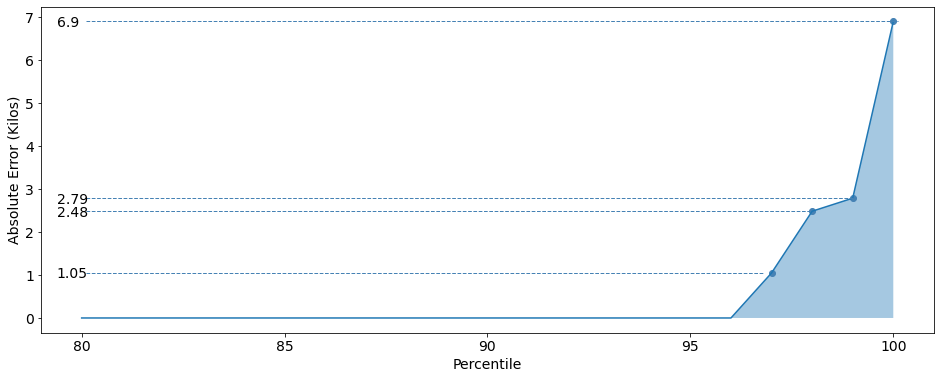

In [16]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (16,6)

plt.plot(q_predictions['q'][80:], q_predictions['diff'][80:])
plt.fill_between(q_predictions['q'][80:], q_predictions['diff'][80:], alpha=0.4)
    
for q in range(97,101):
    x = q_predictions.loc[q]['q']
    y = q_predictions.loc[q]['diff']    
    label = format(y,".3g")
    plt.scatter(x,y, color='steelblue') 
    plt.annotate(label,(80,y),textcoords="offset points", xytext=(-25,-5)) 
    plt.axhline(y = y, color = 'steelblue', linestyle = '--',  linewidth=1, xmin=0.05,xmax=(((x-80)/100)*5)-0.04)

plt.xticks(range(80,101,5))
plt.xlabel('Percentile')
plt.ylabel('Absolute Error (Kilos)')

plt.savefig(os.path.join("..", 'data', 'img_quantiles.png'), bbox_inches='tight', dpi=300)

plt.show()

(10, 16)


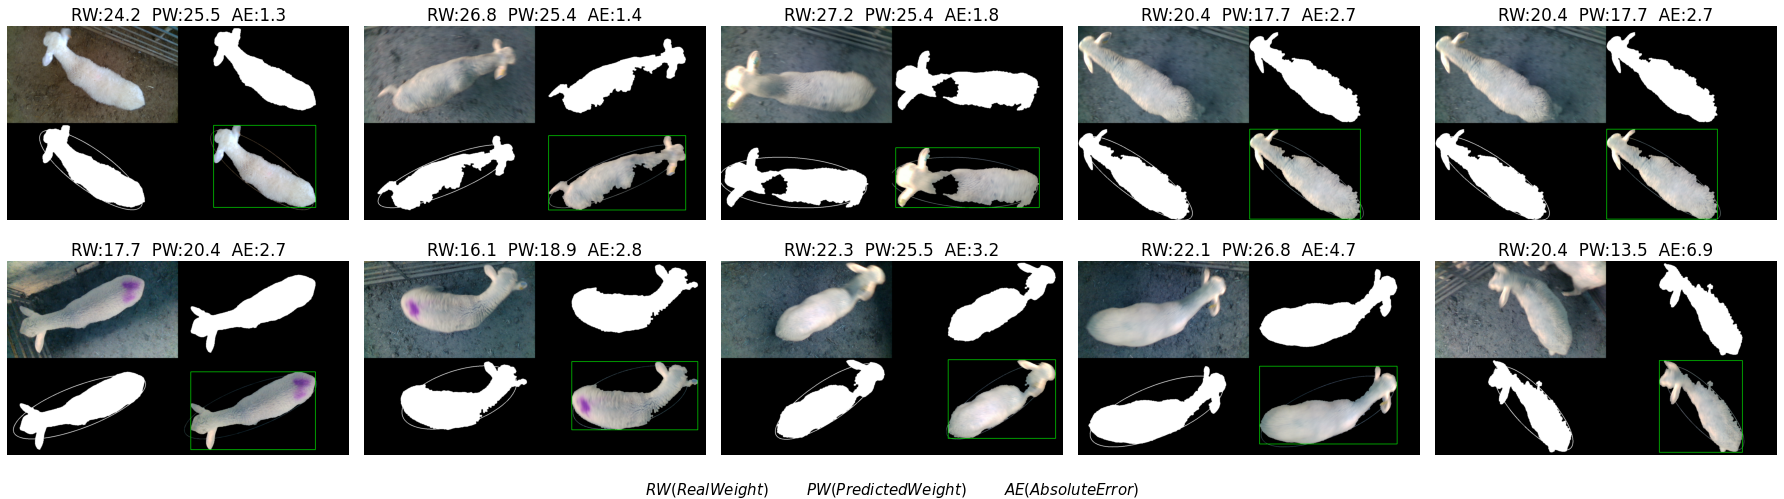

In [17]:
import matplotlib.transforms as mtrans
bad_data = predicted_data[predicted_data['difference']>1].sort_values(by=['difference'],ignore_index=True)
print(bad_data.shape)
max_images = 10
fig, axs = plt.subplots(2,5, figsize=(25,7))

trans = mtrans.blended_transform_factory(fig.transFigure,mtrans.IdentityTransform())
txt = fig.text(0.5, 0, "$\it{RW (Real Weight)}$        $\it{PW (Predicted Weight)}$        $\it{AE (Absolute Error)}$", ha='center', va='bottom', fontsize=15)
txt.set_transform(trans)

for i in range(0,max_images):
    file = bad_data.loc[(i)]
    img=mpimg.imread(os.path.join("..", 'data', 'mosaic', file.uuid+'_mosaico.png'))
    axs[int(i/5)][i%5].imshow(img)
    axs[int(i/5)][i%5].axis('off')
    axs[int(i/5)][i%5].title.set_text('RW:{:.1f}  PW:{:.1f}  AE:{:.1f}'.format(file.weight, file.predicted_weight, abs(file.weight-file.predicted_weight)))

plt.tight_layout()
plt.savefig(os.path.join("..", 'data', 'img_big_diff.png'), bbox_inches='tight', dpi=300)
plt.show()